In [193]:
import numpy as np
import pandas as pd
from scipy.stats import beta,bernoulli,multinomial,norm,binom
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score,recall_score,accuracy_score,f1_score
from sklearn.metrics import plot_confusion_matrix,plot_precision_recall_curve,precision_recall_curve

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.set_style('whitegrid')
sns.set_context('paper',font_scale=2)

%matplotlib inline

# Preparing the Synthetic Data
Using the scheme outlined in the Coston et al. paper.

In [2]:
def sigmoid(X):
    return 1/(1+np.exp(-X))


In [3]:
N = 100000
c = 0.1
k = 1.6

# Z is the single feature that describes an individual
Z = norm(0,1).rvs(N)
# A is a binary demographic group indicator (e.g., Male or Female)
A = bernoulli(0.5).rvs(N)
# outcome under baseline (or no) treatment - note that it only depends on Z
Y_0 = binom(1,sigmoid(Z-0.5)).rvs()
# outcome under treatment - also only depends on Z 
# but probability of adverse outcome under treatment is lower than outcome under baseline
Y_1 = binom(1,c*sigmoid(Z-0.5)).rvs()
# treatment is different for the two groups (A = 0 and A = 1)
T = binom(1,sigmoid(Z-0.5+k*A)).rvs()
Y = T*Y_1 + (1-T)*Y_0

In [4]:
# prepare a dataframe for easier analysis
df = pd.DataFrame(np.vstack([Z,A,T,Y_1,Y_0,Y]).T,
                  columns=['Feature 1','Group','Treatment',
                           'Outcome_Treatment','Outcome_Control','Outcome'])

df.loc[df['Group'] == 1,'Group'] = 'Female'
df.loc[df['Group'] == 0,'Group'] = 'Male'
for c in ['Treatment','Outcome_Treatment','Outcome_Control','Outcome']:
    df.loc[df[c] == 1,c] = 'Yes'
    df.loc[df[c] == 0,c] = 'No'


In [5]:
df.head(10)

,Feature 1,Group,Treatment,Outcome_Treatment,Outcome_Control,Outcome
0,0.621726,Female,Yes,No,Yes,No
1,0.078687,Male,Yes,No,Yes,No
2,-0.037332,Female,Yes,No,Yes,No
3,1.216662,Male,Yes,No,Yes,No
4,0.630157,Female,Yes,No,No,No
5,0.189140,Male,Yes,No,No,No
6,-0.298986,Female,No,No,No,No
7,-0.855936,Female,Yes,No,Yes,No
8,-0.177701,Female,Yes,No,Yes,No
9,-2.145716,Female,Yes,No,No,No


In [6]:
# adverse outcome is significantly higher when treatment is not given
print('Adverse outcome when baseline is given: {}'.format(df.loc[df['Outcome_Control'] == 'Yes'].shape[0]/df.shape[0]))
print('Adverse outcome when treatment is given: {}'.format(df.loc[df['Outcome_Treatment'] == 'Yes'].shape[0]/df.shape[0]))


Adverse outcome when baseline is given: 0.39601
Adverse outcome when treatment is given: 0.03932


In [7]:
# two groups receive treatment at a different rate
df_tmp = pd.DataFrame(df.groupby('Group')['Feature 1'].size()).join(pd.DataFrame(df.groupby(['Group','Treatment'])['Feature 1'].size()),lsuffix='_l')
print(df_tmp['Feature 1']/df_tmp['Feature 1_l'])

Group   Treatment
Female  No           0.281464
        Yes          0.718536
Male    No           0.603413
        Yes          0.396587
dtype: float64


In [8]:
df.groupby(['Treatment']).size()

Treatment
No     44164
Yes    55836
dtype: int64

# Some Basics
If $Y$ is a binary random variable, i.e., $Y \in \{0,1\}$, then:

$$\mathbb{E}[Y] \equiv P(Y = 1)$$

# Terminology
- $T \in \{0,1\}$ is the treatment decision (0 - no treatment/service, 1 - yes treatment/service)

- $Y \in \{0,1\}$ is the binary outcome (1 - bad outcome, e.g., homelessness)
  * $Y^0 \in \{0,1\}$ - outcome when treatment is not provided
  * $Y^1 \in \{0,1\}$ - outcome when treatment is provided

## Two types of models
- An **observation model** produces $\mathbb{E}[Y\vert X]$ or $P(Y = 1|X = x)$, i.e., probability (risk) of an adverse outcome, for an individual with features $x$
  * Issue with this model is that it may underestimate risk for cases that were historically responsive to the treatment
  > Why??
    - Any individual who does not show adverse outcome after treatment, could be assigned a lower risk for adverse outcome by the model
  * Trained using then entire training data set, ignoring the treatment
- A **counterfactual model** produces $\mathbb{E}[Y^0\vert X]$ or $P(Y^0 = 1|X = x)$, i.e., probability (risk) of an adverse outcome, for an individual with features $x$, when no treatment is provided
  * Key assumption: 
  $$\mathbb{E}[Y^0\vert X] \equiv \mathbb{E}[Y\vert X,T = 0]$$
  * Holds if the following three assumptions are true:
    - Consistency: $Y = T Y^1 + (1-T) Y^0$
    - Exchangeability: $Y^0 \perp T \vert X$
    - Weak positivity requirement: $P(\pi(X) < 1)) = 1$, there is a non-zero chance for any $X$ to get no treatment
      > $\pi(X) = P(T = 1\vert X)$, i.e., probability that $X$ will get a treatment
  * Counterfactual model is trained by applying any probabilistic classifier to the control population ($T = 0$)

# Evaluating the observational model and the counterfactual model

In [294]:
# Break the data into two parts
r = np.random.permutation(Z.shape[0])
train_inds = r[0:75000]
test_inds = r[75000:]
X = np.vstack((Z,A)).T
X_train = X[train_inds,:]
X_test = X[test_inds,:]
y_train = Y[train_inds]
y_test = Y[test_inds]
T_train = T[train_inds]

# get the control population
control_inds = np.where(T == 0)[0]
# prepare training data for counterfactual model
train_control_inds = np.array(list(set(train_inds).intersection(set(control_inds))))
X_control_train = X[train_control_inds,:]
y_control_train = Y[train_control_inds]

# prepare testing data for control evaluation
test_control_inds = np.array(list(set(test_inds).intersection(set(control_inds))))
X_control_test = X[test_control_inds,:]
y_control_test = Y[test_control_inds]

# prepare testing data for true counterfactual evaluation
cf_inds = np.where(Y_0 == 1)[0]
test_cf_inds = np.array(list(set(test_inds).intersection(set(cf_inds))))
X_cf_test = X[test_cf_inds,:]
y_cf_test = Y[test_cf_inds]


In [295]:
# Training the model
obs_model = LogisticRegression(solver='lbfgs')
#obs_model = DecisionTreeClassifier()
obs_model = obs_model.fit(X_train,y_train)

cf_model = LogisticRegression(solver='lbfgs')
#cf_model = DecisionTreeClassifier()
cf_model = cf_model.fit(X_control_train,y_control_train)

# also need the propensity model
prop_model = LogisticRegression(solver='lbfgs')
prop_model = prop_model.fit(X_train,T_train)

## Evaluating the two models
The paper discusses four ways to evaluate the models:
1. Observational evaluation
2. Control population evaluation
3. Doubly-robust counterfactual evaluation
4. True counterfactual rates (can only do this for synthetic data)

### Evaluation metrics
- Precision
- True positive rate (TPR)
- False positive rate (FPR)
- Calibration




### 1. Observational evaluation
- Precision-recall curve
  * Observational precision ($\mathbb{E}[Y\vert \hat{Y} = 1]$) vs. observational recall or TPR ($\mathbb{E}[\hat{Y}\vert Y= 1]$)
- ROC curve
- Calibration curve

This has issues (need to understand this better)

- $Y \neq Y^0$



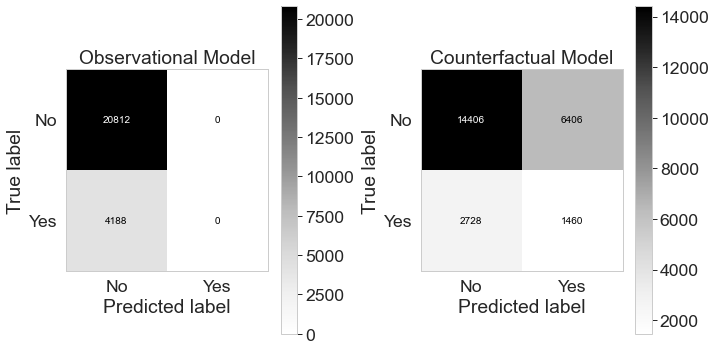

In [296]:
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(121)
plot_confusion_matrix(obs_model, X_test, y_test,display_labels=['No','Yes'],cmap=plt.cm.Greys,ax=ax)
plt.grid(None)
ax.set_title('Observational Model')
ax = plt.subplot(122)
plot_confusion_matrix(cf_model, X_test, y_test,display_labels=['No','Yes'],cmap=plt.cm.Greys,ax=ax)
plt.grid(None)
ax.set_title('Counterfactual Model')
plt.tight_layout()


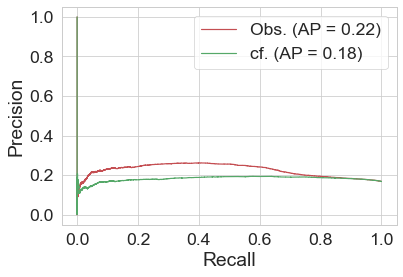

In [297]:
ax = plt.subplot(111)
plot_precision_recall_curve(obs_model,X_test, y_test,ax = ax,name='Obs.',c='r')
plot_precision_recall_curve( cf_model,X_test, y_test,ax = ax,name='cf.' ,c='g')
ax.legend()

The paper says (Section 3.2.1) that the observational model will underestimate the risk for **cases** that were 
historically responsive to treatment. As we see above, model indeed assigns a low risk to everyone (including those who were historically responsive to the treatment).

### 2. Evaluating on the control population only 
Estimate using the control population only, i.e., for which $T = 0$
- Precision-recall curve
  * Control precision ($\mathbb{E}[Y\vert \hat{Y} = 1, T = 0]$) vs. control recall or TPR ($\mathbb{E}[\hat{Y}\vert Y= 1, T = 0]$)
- Similarly for ROC and calibration curves



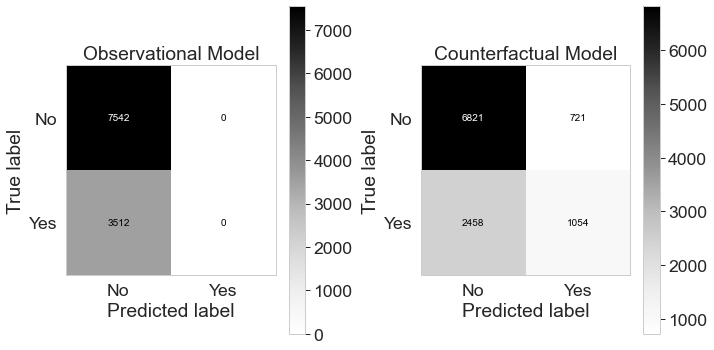

In [298]:
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(121)
plot_confusion_matrix(obs_model, X_control_test, y_control_test,display_labels=['No','Yes'],cmap=plt.cm.Greys,ax=ax)
plt.grid(None)
ax.set_title('Observational Model')
ax = plt.subplot(122)
plot_confusion_matrix(cf_model, X_control_test, y_control_test,display_labels=['No','Yes'],cmap=plt.cm.Greys,ax=ax)
plt.grid(None)
ax.set_title('Counterfactual Model')
plt.tight_layout()



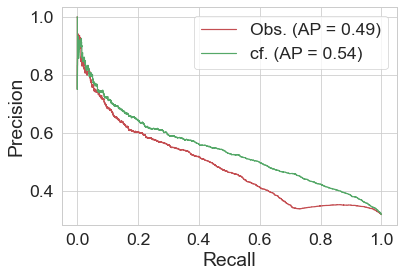

In [299]:
ax = plt.subplot(111)
plot_precision_recall_curve(obs_model,X_control_test, y_control_test,ax = ax,name='Obs.',c='r')
plot_precision_recall_curve( cf_model,X_control_test, y_control_test,ax = ax,name='cf.' ,c='g')
ax.legend()

### 3. Doubly-robust counterfactual evaluation

In [300]:
pi_pred = prop_model.predict_proba(X_test)[:,1]
s_hat_0 = cf_model.predict_proba(X_test)[:,1]

In [315]:
#calculate DR-recall and DR-precision for the two models
dr_obs = []
den_dr_recall = np.mean(((1 - T[test_inds])/(1 - pi_pred))*(y_test - s_hat_0) +  s_hat_0)
y_prob_obs = obs_model.predict_proba(X_test)[:,1]

for s in np.linspace(0,1,1000):
    #recall - obs
    y_pred_obs = np.zeros(y_prob_obs.shape)
    y_pred_obs[y_prob_obs > s] = 1    
    num_dr_recall_obs = np.mean(y_pred_obs*(((1 - T[test_inds])/(1 - pi_pred))*(y_test - s_hat_0) +  s_hat_0))
    #precision - obs
    num_dr_prec_obs = np.mean((((1 - T[test_inds])/(1 - pi_pred))*(y_test - s_hat_0) +  s_hat_0)*y_pred_obs)
    den_dr_prec_obs = np.mean(y_pred_obs)
    if den_dr_prec_obs == 0:
        continue
    dr_obs.append((num_dr_recall_obs/den_dr_recall,num_dr_prec_obs/den_dr_prec_obs))
    
dr_obs = np.array(dr_obs)


In [316]:
#calculate DR-recall and DR-precision for the two models
dr_cf = []
den_dr_recall = np.mean(((1 - T[test_inds])/(1 - pi_pred))*(y_test - s_hat_0) +  s_hat_0)
y_prob_cf = cf_model.predict_proba(X_test)[:,1]

for s in np.linspace(0,1,1000):
    
    #recall - cf
    y_pred_cf = np.zeros(y_prob_cf.shape)
    y_pred_cf[y_prob_cf > s] = 1    
    num_dr_recall_cf = np.mean(y_pred_cf*(((1 - T[test_inds])/(1 - pi_pred))*(y_test - s_hat_0) +  s_hat_0))
    #precision - cf
    num_dr_prec_cf = np.mean((((1 - T[test_inds])/(1 - pi_pred))*(y_test - s_hat_0) +  s_hat_0)*y_pred_cf)
    den_dr_prec_cf = np.mean(y_pred_cf)
    if den_dr_prec_cf == 0:
        continue
    dr_cf.append((num_dr_recall_cf/den_dr_recall,num_dr_prec_cf/den_dr_prec_cf))
dr_cf = np.array(dr_cf)

Text(0, 0.5, 'Precision')

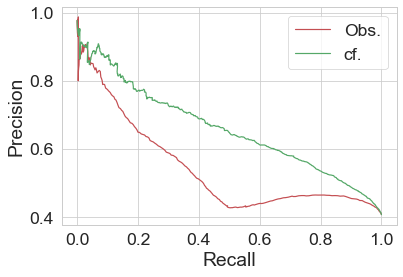

In [317]:
ax = plt.subplot(111)
ax.plot(dr_obs[:,0],dr_obs[:,1],label='Obs.',c='r')
ax.plot(dr_cf[:,0],dr_cf[:,1],label='cf.',c='g')
ax.legend()
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')

### 4. True counterfactual 
- Counterfactual TPR:
$$
\mathbb{E}[\hat{Y}\vert Y^0 = 1]
$$
- Counterfactual Precision:
$$
\mathbb{E}[Y^0\vert \hat{Y} = 1]
$$
- Counterfactual FPR:
$$
\mathbb{E}[\hat{Y}\vert Y^0 = 0]
$$
- Calibration
$$
\mathbb{E}[Y^0\vert r_1 \le \hat{s}(X) \le r_2]
$$
> $\hat{s}_0(X)$ is the probabilistic score (for being a positive outcome) assigned by the model




In [287]:
y_cf_prob_obs = obs_model.predict_proba(X_cf_test)[:,0]
[p_obs,r_obs,t_obs] = precision_recall_curve(y_cf_test,y_cf_prob_obs)
y_cf_prob_cf = cf_model.predict_proba(X_cf_test)[:,0]
[p_cf,r_cf,t_cf] = precision_recall_curve(y_cf_test,y_cf_prob_cf)

Text(0, 0.5, 'Precision')

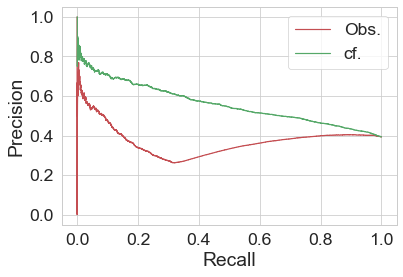

In [288]:
ax = plt.subplot(111)
ax.plot(r_obs,p_obs,label='Obs.',c='r')
ax.plot(r_cf,p_cf,label='cf.',c='g')
ax.legend()
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')